**Cole Turner and Ethan Seal**

Fall 2019

CS343: Neural Networks

Project 4: Transfer Learning

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3) DeepDream

You will make use of a pre-trained neural network (VGG16) to implement the DeepDream (gradient ascent) algorithm using TensorFlow 2.0. The algorithm projects the receptive fields of specific filters and/or layers onto the input image to create some trippy effects! A neat side effect of this process is that you can visualize how learned weights at different levels of the network interact with parts of the input image.

This task will expose you to Tensorflow's low level API that operates on image data in the Tensorflow Tensor data structure.

### Overview of the algorithm

- Load in the VGG16 pre-trained network without the output layer.
- Make a `keras` "Model" that allows us to reference the activation (output) of each VGG16 network layer.
- Select the types of layers (e.g. conv, pooling, etc) that we want to use to run Deep Dream on to influence the input image.
- Pass image through the network, compute the netAct values and gradient at the selected layers.
- Do gradient ascent where we add a proportion of the gradient from a network layer back into the image for some number of iterations.

### 3a) Import mountain image

The below code loads in the mountain test image at 224 x 224 resolution (1x). This matches the resolution of images on which VGG16 was trained.

NOTE: If you have a more powerful machine (or are willing to wait longer for prettier pictures), you can use the 2x or 3x images.

Image size is (224, 224, 3)


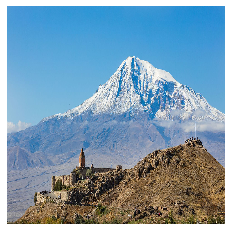

Image min/max is: 0.0/1.0. It should be 0.0/1.0


In [27]:
img_filename = os.path.join('data', 'mountain_1x.png')
img = plt.imread(img_filename)
print(f'Image size is {img.shape}')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

print(f'Image min/max is: {img.min()}/{img.max()}. It should be 0.0/1.0')

### b. Load in pre-trained VGG16 network.

**TODO:**
- Like what you did on the Transfer Learning Task, load in the pre-trained VGG16 network and set it to a variable called `vgg`. Don't load/include the trained output layer. https://www.tensorflow.org/api_docs/python/tf/keras/applications

If you call the `summary()` method on the network object, you should see a table with many rows. The top and bottom rows should be:

    input_6 (InputLayer)         [(None, 224, 224, 3)]     0    
    block5_pool (MaxPooling2D)   (None, 7, 7, 512)       0 

and you should see the following at the bottom:

    Total params: 14,714,688
    Trainable params: 14,714,688
    Non-trainable params: 0

In [28]:
vgg = tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3),weights='imagenet')

vgg.trained=False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 3c) Reference network layers/neurons whose activation we want to sample

Define the layers and/or specific neurons whose activity we will increase by adding their gradient (increase of activity) within their receptive fields back into the input image.

In [29]:
# Create a list of all NON-INPUT layer names in the VGG16 network.
# These are the strings in the left-most column in the `summary()` view above.
all_layer_names = [layer.name for layer in vgg.layers]
all_layer_names = all_layer_names[1:]

# Make a list of references to each layer's netAct values (`output` fields) of every NON-INPUT LEVEL layer object.
# Reference here is important bc we haven't showed the network the mountain image yet! But once we do,
# `layers` will point to the resulting activations.
layers = [vgg.get_layer(name).output for name in all_layer_names]

# Make a keras 'Model' object that will allow us to pass in the input image
# and get the activations (outputs) at each network level
tf_net = tf.keras.Model(inputs=vgg.input, outputs=layers)

**TODO**:
- Create a Python list that stores the string NAMES of non-input layers that contain the substring `layer_str`. There should be 5 pooling layers.
- Create a Python list that stores the INDICES of `layer_str` matchs from the big list of all non-input layer strings. The indices for the pooling layers should be `[2, 5, 9, 13, 17]`.

In [30]:
layer_str = 'pool' 

pool_indices = []
for i in range(len(all_layer_names)):
    if layer_str in all_layer_names[i]:
        pool_indices.append(i)

print(pool_indices)

[2, 5, 9, 13, 17]


### 3d) Compute network activation to input image

Below, you will pass the input image to the network to compute the forward pass activations (netAct) in each network layer. This is a basic step in the DeepDream algorithm.

**TODO:**
- Make a new `tf.Variable` object from the numpy image data `img`.
- Create a new `DeepDream` object, passing in all the necessary parameters for all the pooling layers in the network.
- Implement `forward()` in `DeepDream`
- Run `forward()` on the 1x mountain image with `filter_inds=[]`. If everything works, you should get the following mean netAct values from each respective the Max Pooling layer: `[2.60964131, 4.14118576, 4.03892231, 0.559926271, 0.152407467]`
- Run `forward()` on the 1x mountain image with `filter_inds=[55, 56]`. If everything works, you should get the following mean netAct values from each respective the Max Pooling layer: `[2.79232359, 3.4536202, 1.45324707, 0.214050353, 0.716764092]`

In [31]:
from deep_dream import *

In [32]:
tf_img = tf.Variable(img)
dreamer = DeepDream(tf_net, pool_indices, all_layer_names)
netActs = dreamer.forward(tf_img, True)
tf.print(netActs)

[<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'block1_conv1_2/Identity:0' shape=(None, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_conv2_2/Identity:0' shape=(None, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool_2/Identity:0' shape=(None, 112, 112, 64) dtype=float32>, <tf.Tensor 'block2_conv1_2/Identity:0' shape=(None, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_conv2_2/Identity:0' shape=(None, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool_2/Identity:0' shape=(None, 56, 56, 128) dtype=float32>, <tf.Tensor 'block3_conv1_2/Identity:0' shape=(None, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_conv2_2/Identity:0' shape=(None, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_conv3_2/Identity:0' shape=(None, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool_2/Identity:0' shape=(None, 28, 28, 256) dtype=float32>, <tf.Tensor 'block4_conv1_2/Identity:0' shape=(None, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_conv2_2/Identity:0' 

ValueError: Attempt to convert a value (<tensorflow.python.keras.engine.training.Model object at 0x0000024B0D7396A0>) with an unsupported type (<class 'tensorflow.python.keras.engine.training.Model'>) to a Tensor.

**Question 6:** Describe briefly in your own words the meaning of each of the single float values returned by `forward` (i.e. what does each number in the test code results represent)? You don't need to give 5 answers, just what does the $i^{th}$ one mean?

### 3e) Compute normalized gradients of each layer with respect to input image

In this subtask, you will implement "gradient tracking" so that when you perform a forward pass on the image, you get gradients computed automatically for you. You will collect these recorded gradients and normalized them. This is a basic step in the Deep Dream algorithm.

**TODO:**
Implement `image_gradient()` in `deep_dream.py`.

The normalization should follow the equation $$\hat{g} = g / \left (\sqrt{\textit{mean} \left ( g^2 \right )} +\epsilon \right)$$ where $g$ is the current gradient tensor and $\epsilon$ is a small number to prevent division by 0 (e.g. `1e-8`). Look up the appropriate functions in `tf.math` to do the job.

In [ ]:
img_grads = dream.image_gradient(img_tf, verbose=False)
[tf.reduce_sum(grad) for grad in img_grads]

The above test code should result in the following for the 1x mountain image with all Max Pooling layers:
    
    [<tf.Tensor: id=126262, shape=(), dtype=float32, numpy=8398.205>,
     <tf.Tensor: id=126264, shape=(), dtype=float32, numpy=1234.3369>,
     <tf.Tensor: id=126266, shape=(), dtype=float32, numpy=439.02655>,
     <tf.Tensor: id=126268, shape=(), dtype=float32, numpy=214.38934>,
     <tf.Tensor: id=126270, shape=(), dtype=float32, numpy=16.045189>]

### 3f) Implement gradient ascent algorithm

This is where we bring the `forward` and `image_gradient` steps together to actually perform DeepDream on the image. The result is a surreal, trippy, dreamy effect that merges the neural and image representations.

**TODO:**
- Implement `gradient_ascent` in `deep_dream.py`. The updating process follows the equation $$x_{t+1} = x_t + \Delta_i \times s$$ where $x$ is the image tensor (*there is a t subscript because the image is changing as the neural signals affect it over time*), $\Delta_i$ is the gradient for the $i^{th}$ selected network layer, and $s$ is the step size.
- Implement `tf2array` in `deep_dream.py`. We need this to visualize the results of DeepDream!
- Paste and adapt your code from Task 3d above in the cell below to create a tf.Variable version of img, have the network 'dream' based on the activations of the **LAST selected layer only** (for this test), create a DeepDream object, call gradient ascent to create `dream_img`.

**NOTE:** It may be helpful to print (if verbose) the current iteration of gradient ascent to get a sense of progress.

Run the below code to visualize your dream image

In [ ]:
# Image created after running Deep Dream (gradient ascent) for 20 iterations
deep_img_np = dream.tf2array(dream_img)

fig = plt.figure(figsize=(10, 10))
plt.imshow(deep_img_np)
plt.xticks([])
plt.yticks([])
plt.show()

### 3g) Multi-scale Deep Dream / gradient ascent

While the existing algorithm results in some cool effects, some small additional work can make the DeepDream images look a lot better.

**TODO:**
- Implement `gradient_ascent_multiscale` in `deep_dream.py`. In this version, you will apply gradient ascent like before, but now we will scale (enlarge) the image after doing so, then run gradient ascent again on the larger image (repeating the process several times). 
- Paste and adapt your code from Task 3f above in the cell below: create a tf.Variable version of img, have the network 'dream' based on the activations of the **LAST selected layer only** (for this test), create a DeepDream object, call gradient ascent to create `dream_img`.

Run the below code to visualize your dream image

In [ ]:
# Image created after running Deep Dream (gradient ascent) for 10 iterations
# with scale_factor = 1.3 and 4 image resizings
deep_img_np = dream.tf2array(dream_img)

fig = plt.figure(figsize=(10, 10))
plt.imshow(deep_img_np)
plt.xticks([])
plt.yticks([])
plt.show()

**Question 7:** Give at least two reasons why the multi-scale version tends to produce better visualizations. Hint: think about the filter receptive fields involved in the process.

### 3h) Explore deep dream / gradient ascent algorithm

**TODO**: Generate several DeepDream images to accompany each of your written answers to the following questions. You can include them inline with your answers below.

**Question 7**: What differences do you notice if you only use earlier/later network layers to do the deep dream process?

**Question 8**: Describe what you notice when you let all max pooling layers contribute to the deep dream image.

**Question 9**: What happens when you pick specific filters to project rather than average all unit activation in a layer?

**Question 10**: Do you notice any difference when selecting a different layer type to do the Deep Dream process (other than max pooling)?

## Extensions

### 1. Run Deep Dream on your own images. Make some interesting effects.

Note that you will likely have to convert images from uint8 to float32 and normalize to the [0, 1] range.

You will probably want to resize your images as part of the preprocessing to keep simulation time reasonable.

Play with the number of gradient ascent iterations.

### 2. Research other pretrained networks in tensorflow and run DeepDream on their layers/filters.

### 3. Automate the visualization process for many filters and/or subsets of layers. Make grids of output images. Do you find patterns in any of the filters?

### 4. Transfer learning: What's the best test accuracy that you can achieve on the hot dog or not dataset? How did you do it?

### 5. Keras ConvNet4: Explore and analyze how different network architectures affect the STL-10 results.

### 6. Transfer learning: Can you apply Transfer learning to a binary or multi-class classification task with another dataset of your choice?